In [3]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [7]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [9]:
query= text("SELECT DATE(datefrom) AS date, toid, SUM(datavalue) AS datavalue FROM movements GROUP BY date, toid ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True) 
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

             date                toid  datavalue
0      2019-08-01  08|033|001|000|000       3649
1      2019-08-01  08|033|002|000|000       7193
2      2019-08-01  08|033|003|000|000       2245
3      2019-08-01  08|033|004|000|000       6263
4      2019-08-01  08|033|005|000|000       3571
...           ...                 ...        ...
28543  2019-09-30  08|099|024|000|000       4078
28544  2019-09-30  08|099|025|000|000      10383
28545  2019-09-30  08|099|026|000|000       2919
28546  2019-09-30  08|099|027|000|000       2315
28547  2019-09-30  08|099|999|000|255      55142

[28548 rows x 3 columns]


In [11]:
from sklearn.preprocessing import LabelEncoder
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["weekday"] = df["date"].dt.weekday
df["week"] = df["date"].dt.isocalendar().week - df["date"].dt.isocalendar().week.min()
df['weekend'] = df['weekday'].apply(lambda w: 1  if (w == 5 or w == 6) else 0)
#df["date"] = df['date'].astype('int64')
label_encoder = LabelEncoder()
df['toid'] = label_encoder.fit_transform(df['toid'])
df

,date,toid,datavalue,weekday,week,weekend
0,2019-08-01,0,3649,3,0,0
1,2019-08-01,1,7193,3,0,0
2,2019-08-01,2,2245,3,0,0
3,2019-08-01,3,6263,3,0,0
4,2019-08-01,4,3571,3,0,0
...,...,...,...,...,...,...
28543,2019-09-30,463,4078,0,9,0
28544,2019-09-30,464,10383,0,9,0
28545,2019-09-30,465,2919,0,9,0
28546,2019-09-30,466,2315,0,9,0


In [22]:
from sklearn.model_selection import train_test_split

# Estrai giorni unici 
unique_days = df['date'].unique()

# Split dei giorni
train_days, test_days = train_test_split(unique_days, test_size=0.3)

# Filtra righe 
train_df = df[df['date'].isin(train_days)].copy()
test_df = df[df['date'].isin(test_days)].copy()

# Conversione numerica della data 
train_df['date'] = train_df['date'].astype('int64')
test_df['date'] = test_df['date'].astype('int64')

# Separazione X e y
X_train = train_df.drop(['datavalue'], axis='columns')
y_train = train_df['datavalue']
X_test = test_df.drop(['datavalue'], axis='columns')
y_test = test_df['datavalue']

In [24]:
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import MinMaxScaler


Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_train_scaled_GB = np.log1p(y_train)
y_test_scaled_GB = np.log1p(y_test)
scaler = MinMaxScaler()
X_train_scaled_GB = scaler.fit_transform(X_train)
X_test_scaled_GB = scaler.transform(X_test)

Model_GB = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100, 300, 500],  
    'learning_rate': [0.01, 0.1, 0.2],  
    'max_depth': [3, 5, 7]  
}

grid_search = GridSearchCV(estimator=Model_GB, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_GB, y_train_scaled_GB)
print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori parametri trovati: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}


*** Gradient Boosting ***
MAE = 968.6212221158813
MAPE = 8.921001621253538 %


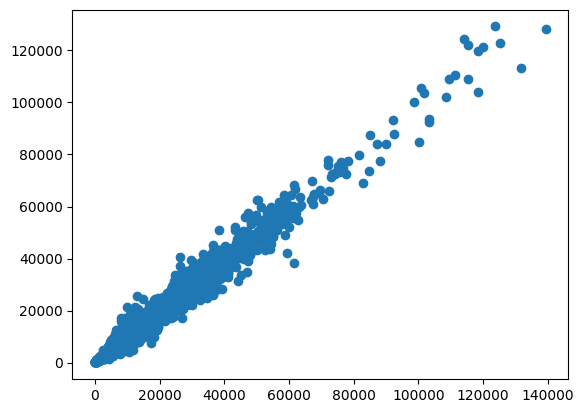

In [28]:
print("*** Gradient Boosting ***")
best_model = grid_search.best_estimator_
y_pred_GB = best_model.predict(X_test_scaled_GB)

y_pred_GB =np.expm1(y_pred_GB)
y_test =np.expm1(y_test_scaled_GB)
print('MAE =', mean_absolute_error(y_test, y_pred_GB))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_GB)*100,'%')
MAPE_GB = mean_absolute_percentage_error(y_test, y_pred_GB)*100
plt.scatter(y_test, y_pred_GB)
plt.show()

In [31]:
import joblib

# Salvataggio del modello
joblib.dump(best_model, "mobility_model.pkl")

# Salvataggio dello scaler usato prima del training
joblib.dump(scaler, "scaler.pkl")

# Salvataggio del label encoder 
joblib.dump(label_encoder, "label_encoder.pkl")  


['label_encoder.pkl']